<div style="display:block">
   <div style="width: 100%; display: inline-block">
       <center><h1>Diabetes Classification</h1></center>
       <center><div style="width: 100%; display: inline-block;"><i>Author:</i> <strong>siddyboi45</strong> </div></center>
   </div>
</div>

### Importing Required libraries

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Reading dataset

In [2]:
dataset = pd.read_csv('diabetes.csv')

In [3]:
display(dataset.shape)
display(dataset.head(10))
display(dataset.nunique())
display(dataset.dtypes)

(768, 9)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [4]:
# Number of nulls in each column
dataset.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Data exploration

Explore the data to identify small improvements that can be done to improve quality of data

In [5]:
# Checking duplicates
a = dataset.drop_duplicates(keep='first')
print("There were",dataset.shape[0]-a.shape[0],"duplicates!\n")

# Checking duplicates without label column
b = dataset.drop(columns = ['Outcome'])
a = b.drop_duplicates(keep='first')
print("There were",b.shape[0]-a.shape[0],"duplicates after removing label column!\n")

There were 0 duplicates!

There were 0 duplicates after removing label column!



In [6]:
for i in dataset.columns:
    print('There are',dataset[i].isin([0]).sum(),'zeros in column',i)

There are 111 zeros in column Pregnancies
There are 5 zeros in column Glucose
There are 35 zeros in column BloodPressure
There are 227 zeros in column SkinThickness
There are 374 zeros in column Insulin
There are 11 zeros in column BMI
There are 0 zeros in column DiabetesPedigreeFunction
There are 0 zeros in column Age
There are 500 zeros in column Outcome


Features like Glucose, BloodPressure, SkinThickness and BMI do not make sense if they are zero. Insulin and Pregnancies could be zero. So we have to replace the zeros and impute them with mean values after the train-test split.

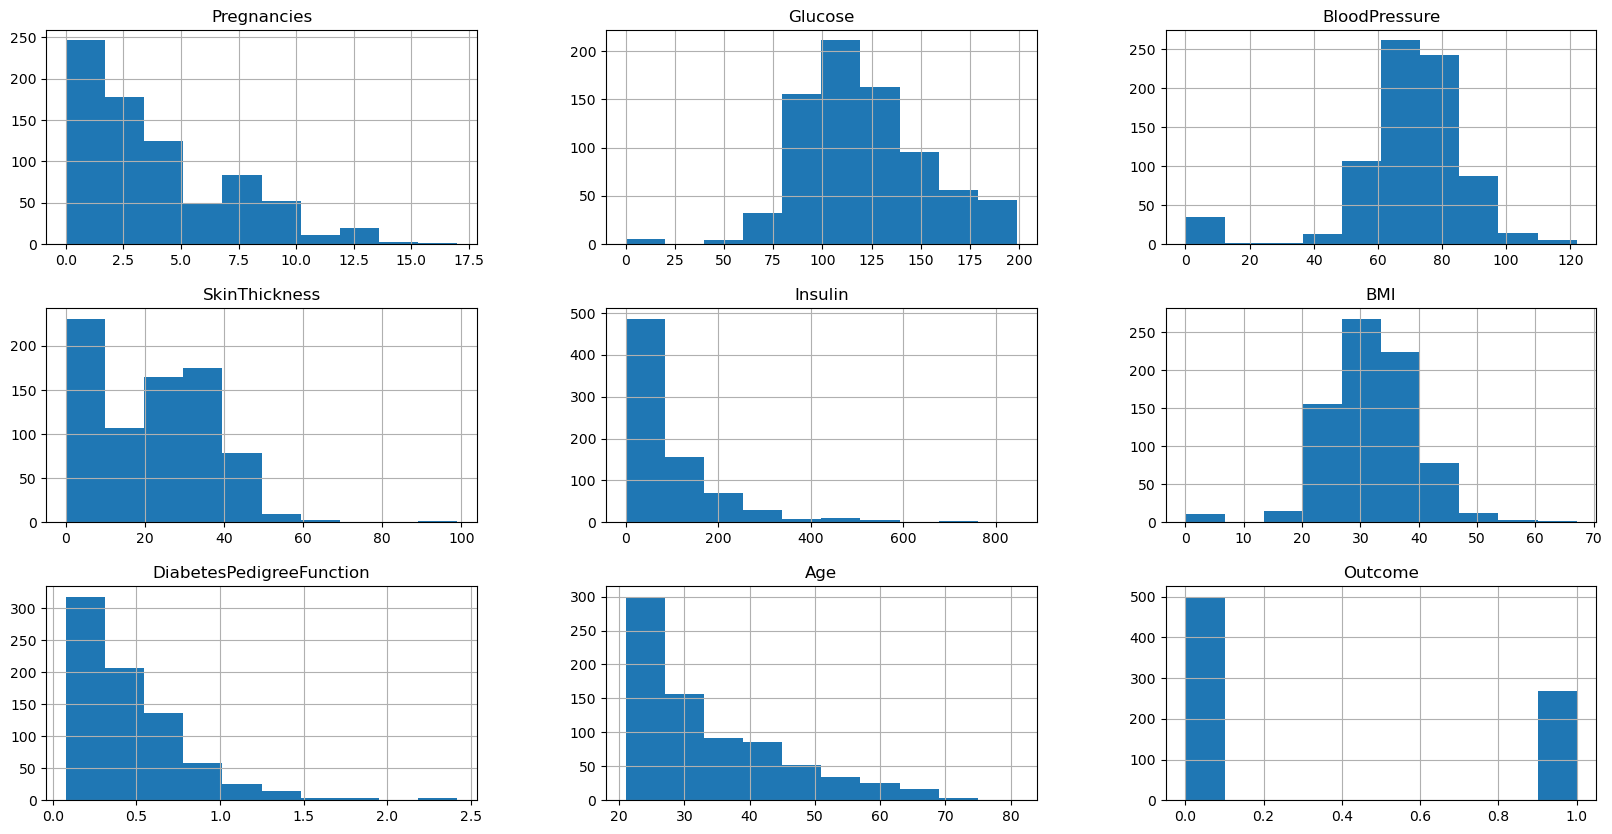

In [7]:
# Plotting the histograms of each variable
dataset.hist(figsize=(20, 10))
plt.show()

Here Glucose, BloodPressure and BMI have a Gaussian distribution and the other variables have a non-Gaussian distribution.

Since all variables are spread across a wide range of values we will standardize the variables

In [8]:
# Check for class imbalance. That is, check if equal amount of data is present for both the classes
dataset['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

The data is significantly higher for the '0' class. So before training the model sampling should be done to remove the class imbalance

### Sigmoid function

In [9]:
def sigmoid(x):
    val = 1/(1 + math.exp(x * (-1)))
    return val

### Predict function

In [10]:
def predict (coeff, X, intercept_flag=0):
    if intercept_flag==1:
        X = X.to_numpy()
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    y_hat = list()
    for obs in X:
        val = coeff[0]
    #     print('Inital val is',val,'\n')
        for i in range(len(obs)):
    #         print('Multiplying',coeff[i+1],'and',obs[i],'\n')
            val = val + coeff[i] * obs[i]
    #         print('Val is',val,'\n')
        y_hat.append(sigmoid (val))
    return np.array(y_hat)

### Loss function

In [11]:
def loss(pred, y):
    if len(pred) != len(y):
        print('Error!')
    else:
#         pred = np.array(pred)
#         y = np.array(y)
        return np.mean(y * np.log(pred) + (1 - y) * np.log(1 - pred)) * (-1)

### Defining Log Regression function

In [12]:
def LogReg(X, y, lr = 0.01, epochs = 10000):
    X = X.to_numpy()
    X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    weights = np.zeros(X.shape[1])

    for i in range(epochs):
        h = predict(weights, X)
        gradient = np.dot(X.T, (h - y)) / y.size
        weights -= lr * gradient

        if(i % 1000 == 0):
            print(f'loss: {loss(h, y)} \t')
    return weights

### Deciding class based on threshold

In [13]:
def pred_class(y, threshold):
    return np.where(y>=threshold,1,0)

### Splitting data and preprocessing

In [14]:
# Split dataset into dependent and independent variables
X = dataset.drop(columns = ['Outcome'])
y = dataset['Outcome']

In [15]:
#Splitting data 60:training, 20:validation, 20:testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=45, stratify = y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=45, stratify = y_train)

In [16]:
for i in ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']:
    X_train[i].replace(0, X_train[i].mean(), inplace = True)
    X_test[i].replace(0, X_test[i].mean(), inplace = True)
    X_valid[i].replace(0, X_valid[i].mean(), inplace = True)

In [17]:
stscaler = StandardScaler()

X_train = pd.DataFrame(stscaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(stscaler.transform(X_test), columns = X_train.columns)
X_valid = pd.DataFrame(stscaler.transform(X_valid), columns = X_train.columns)

In [18]:
# Perform random oversampling to remove class imbalance
oversample = RandomOverSampler(sampling_strategy='minority', random_state = 12)

X_train, y_train = oversample.fit_resample(X_train, y_train)
X_test, y_test = oversample.fit_resample(X_test, y_test)
X_valid, y_valid = oversample.fit_resample(X_valid, y_valid)

In [19]:
X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.825549,-1.175061,-0.486623,0.213520,-0.702892,-0.868723,-0.385479,-0.177750
1,-0.239058,-0.506502,-1.469306,-0.589350,0.616176,-0.233957,-0.552044,-0.754722
2,-1.118794,-0.633846,1.151183,-0.990785,0.173704,-0.470149,0.585676,-0.507449
3,0.054187,2.135899,3.116550,0.414238,-0.702892,-0.588245,0.543329,0.316797
4,-0.532304,-0.315485,0.250390,0.514597,-0.702892,0.474619,-0.958574,-1.001996
...,...,...,...,...,...,...,...,...
595,0.347432,-0.219976,2.133867,-0.590659,-0.702892,3.013682,-0.786363,-0.425024
596,-0.825549,-1.079553,-3.434673,1.518184,0.123613,3.323684,0.023874,-0.589873
597,1.813657,-1.015880,1.069293,0.514597,-0.702892,0.356523,0.952682,1.882863
598,-0.825549,2.358752,0.332280,0.916032,1.375893,0.592715,1.093838,-0.342599


In [20]:
#Train the logistic regression model with the train dataset
weights = LogReg(X_train,y_train, 0.05, 10000)

# Calculate prediction probabilities for test and validation based on weight from training
y_pred_test = predict(weights, X_test, 1)
y_pred_val = predict(weights, X_valid, 1)

# Assign class based predicted probabilities
y_class_test = pred_class(y_pred_test, 0.5)
y_class_val = pred_class(y_pred_val, 0.5)

loss: 0.6931471805599453 	
loss: 0.4743078053014763 	
loss: 0.4742824506613583 	
loss: 0.47428241596301973 	
loss: 0.4742824159070244 	
loss: 0.4742824159069253 	
loss: 0.4742824159069251 	
loss: 0.4742824159069251 	
loss: 0.4742824159069251 	
loss: 0.4742824159069251 	


### Measuring performance on test and validate datasets

In [21]:
print('Accuracy:',accuracy_score(y_test, y_class_test))
print('Precision:',precision_score(y_test, y_class_test))
print('Recall:',recall_score(y_test, y_class_test))
print('F1 Score:',f1_score(y_test, y_class_test))
print('ROC-AUC Score:',roc_auc_score(y_test, y_pred_test))

Accuracy: 0.78
Precision: 0.7857142857142857
Recall: 0.77
F1 Score: 0.7777777777777778
ROC-AUC Score: 0.8679


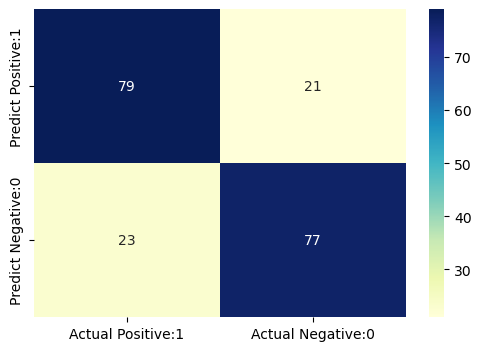

In [22]:
cm = confusion_matrix(y_test, y_class_test)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
plt.figure(figsize=(6,4))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

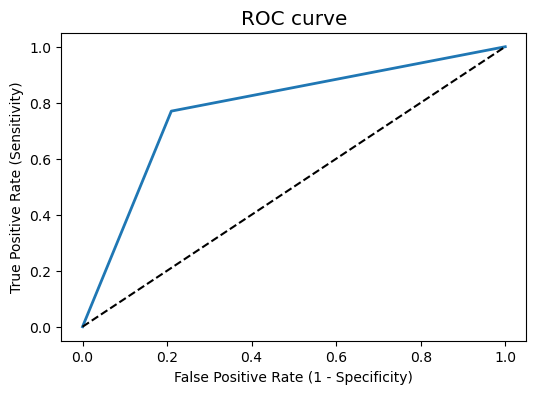

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_class_test, pos_label = 1)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

In [24]:
print('Accuracy:',accuracy_score(y_valid, y_class_val))
print('Precision:',precision_score(y_valid, y_class_val))
print('Recall:',recall_score(y_valid, y_class_val))
print('F1 Score:',f1_score(y_valid, y_class_val))
print('ROC-AUC Score:',roc_auc_score(y_valid, y_pred_val))

Accuracy: 0.76
Precision: 0.8023255813953488
Recall: 0.69
F1 Score: 0.7419354838709676
ROC-AUC Score: 0.8306


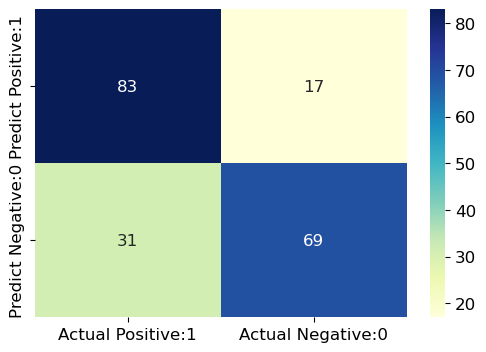

In [25]:
cm = confusion_matrix(y_valid, y_class_val)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
plt.figure(figsize=(6,4))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

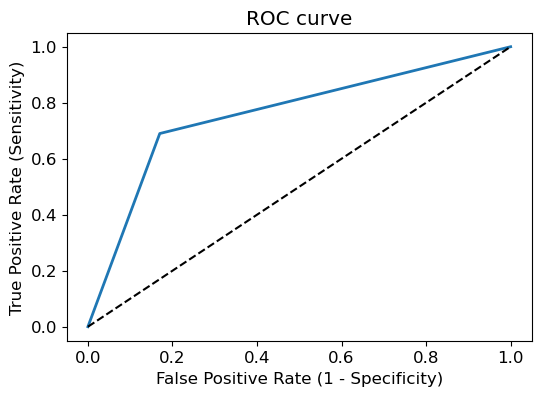

In [26]:
fpr, tpr, thresholds = roc_curve(y_valid, y_class_val, pos_label = 1)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

### Implementation of Neural Networks

#### 1. Building model with 1 hidden layer and l2 regularization

In [27]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import pandas as pd

In [28]:
seed_nb = 12
np.random.seed(seed_nb)
tf.random.set_seed(seed_nb)

# Create neural network base model
model = tf.keras.Sequential()

# Add 1 hidden layer and 1 output layer to the model
# Hidden layer 1
model.add(Dense(12, activation='relu', input_dim=8, kernel_regularizer=tf.keras.regularizers.l2(0.005)))

# Add output layer to the model
model.add(Dense(2, activation='softmax'))

In [29]:
# Compile model
model.compile(optimizer=SGD(learning_rate = 0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                108       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 26        
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
# Training the model
fit_model = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test), 
                      epochs=100, 
                      batch_size=16)

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print('\n\n Loss', loss, 'Accuracy:', accuracy)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/38 [..............................] - ETA: 4s - loss: 0.8146 - accuracy: 0.4375WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x147b72b80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY

38/38 [==============================] - 0s 868us/step - loss: 0.5243 - accuracy: 0.7439 - val_loss: 0.5354 - val_accuracy: 0.7850
Epoch 45/100
38/38 [==============================] - 0s 887us/step - loss: 0.5158 - accuracy: 0.7551 - val_loss: 0.5345 - val_accuracy: 0.7850
Epoch 46/100
38/38 [==============================] - 0s 858us/step - loss: 0.4751 - accuracy: 0.7922 - val_loss: 0.5340 - val_accuracy: 0.7850
Epoch 47/100
38/38 [==============================] - 0s 872us/step - loss: 0.5332 - accuracy: 0.7580 - val_loss: 0.5334 - val_accuracy: 0.7850
Epoch 48/100
38/38 [==============================] - 0s 886us/step - loss: 0.5053 - accuracy: 0.7693 - val_loss: 0.5326 - val_accuracy: 0.7950
Epoch 49/100
38/38 [==============================] - 0s 859us/step - loss: 0.5009 - accuracy: 0.7697 - val_loss: 0.5319 - val_accuracy: 0.7950
Epoch 50/100
38/38 [==============================] - 0s 872us/step - loss: 0.5104 - accuracy: 0.7648 - val_loss: 0.5312 - val_accuracy: 0.7950
Epoch

7/7 [==============================] - 0s 410us/step - loss: 0.5219 - accuracy: 0.8000


 Loss 0.5219453573226929 Accuracy: 0.800000011920929


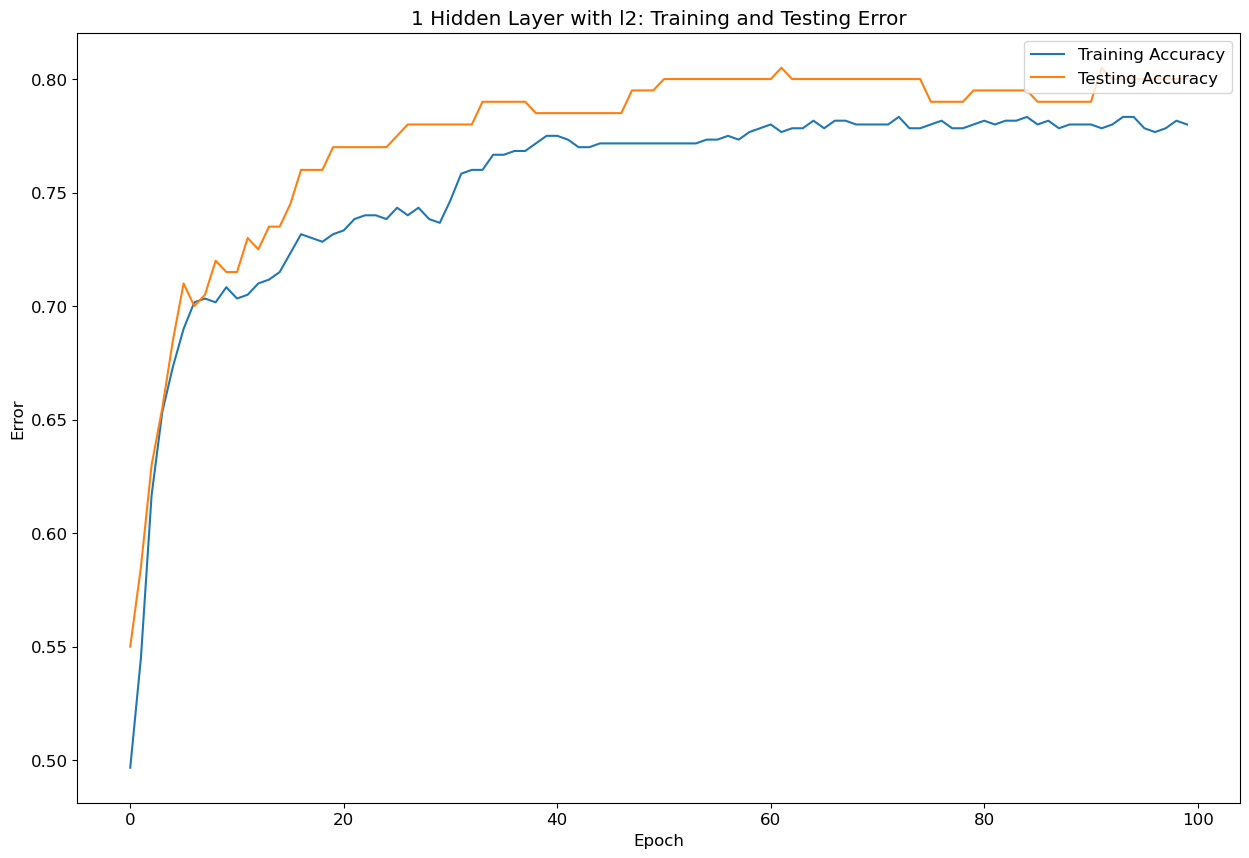

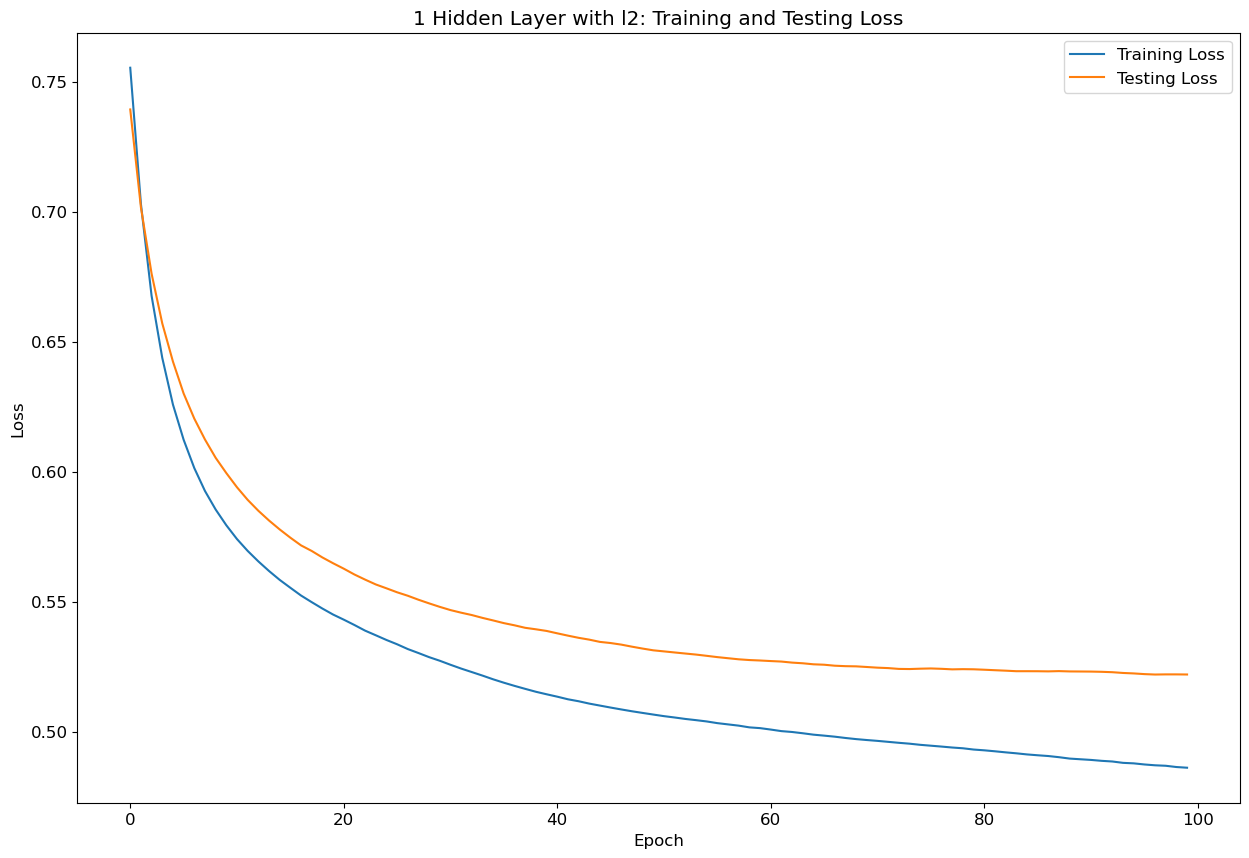

In [31]:
# Plot the accuracy and loss.

# Accuracy
plt.figure(figsize=(15, 10))
plt.plot(fit_model.history['accuracy'])
plt.plot(fit_model.history['val_accuracy'])
plt.title('1 Hidden Layer with l2: Training and Testing Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper right')
plt.show()

# Loss
plt.figure(figsize=(15, 10))
plt.plot(fit_model.history['loss'])
plt.plot(fit_model.history['val_loss'])
plt.title('1 Hidden Layer with l2: Training and Testing Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
plt.show()

#### 2. Building model with 1 hidden layer and l1 regularization

In [32]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import pandas as pd

In [33]:
seed_nb = 12
np.random.seed(seed_nb)
tf.random.set_seed(seed_nb)

# Create neural network base model
model = tf.keras.Sequential()

# Add 1 hidden layer and 1 output layer to the model
# Hidden layer 1
model.add(Dense(12, activation='relu', input_dim=8, kernel_regularizer=tf.keras.regularizers.l1(0.005)))

# Add output layer to the model
model.add(Dense(2, activation='sigmoid'))

In [34]:
# Compile model
model.compile(optimizer=SGD(learning_rate = 0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 26        
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
# Training the model.
fit_model = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test), 
                      epochs=100, 
                      batch_size=16)

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print('\n\n Loss', loss, 'Accuracy:', accuracy)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/38 [..............................] - ETA: 4s - loss: 0.8971 - accuracy: 0.4375WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x158822820> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY

38/38 [==============================] - 0s 897us/step - loss: 0.6099 - accuracy: 0.7503 - val_loss: 0.6244 - val_accuracy: 0.7800
Epoch 45/100
38/38 [==============================] - 0s 886us/step - loss: 0.6049 - accuracy: 0.7402 - val_loss: 0.6235 - val_accuracy: 0.7800
Epoch 46/100
38/38 [==============================] - 0s 883us/step - loss: 0.5603 - accuracy: 0.7799 - val_loss: 0.6231 - val_accuracy: 0.7800
Epoch 47/100
38/38 [==============================] - 0s 872us/step - loss: 0.6186 - accuracy: 0.7432 - val_loss: 0.6224 - val_accuracy: 0.7800
Epoch 48/100
38/38 [==============================] - 0s 861us/step - loss: 0.5905 - accuracy: 0.7607 - val_loss: 0.6215 - val_accuracy: 0.7800
Epoch 49/100
38/38 [==============================] - 0s 826us/step - loss: 0.5880 - accuracy: 0.7646 - val_loss: 0.6206 - val_accuracy: 0.7800
Epoch 50/100
38/38 [==============================] - 0s 852us/step - loss: 0.5982 - accuracy: 0.7551 - val_loss: 0.6199 - val_accuracy: 0.7800
Epoch

7/7 [==============================] - 0s 374us/step - loss: 0.6129 - accuracy: 0.7950


 Loss 0.6129276752471924 Accuracy: 0.7950000166893005


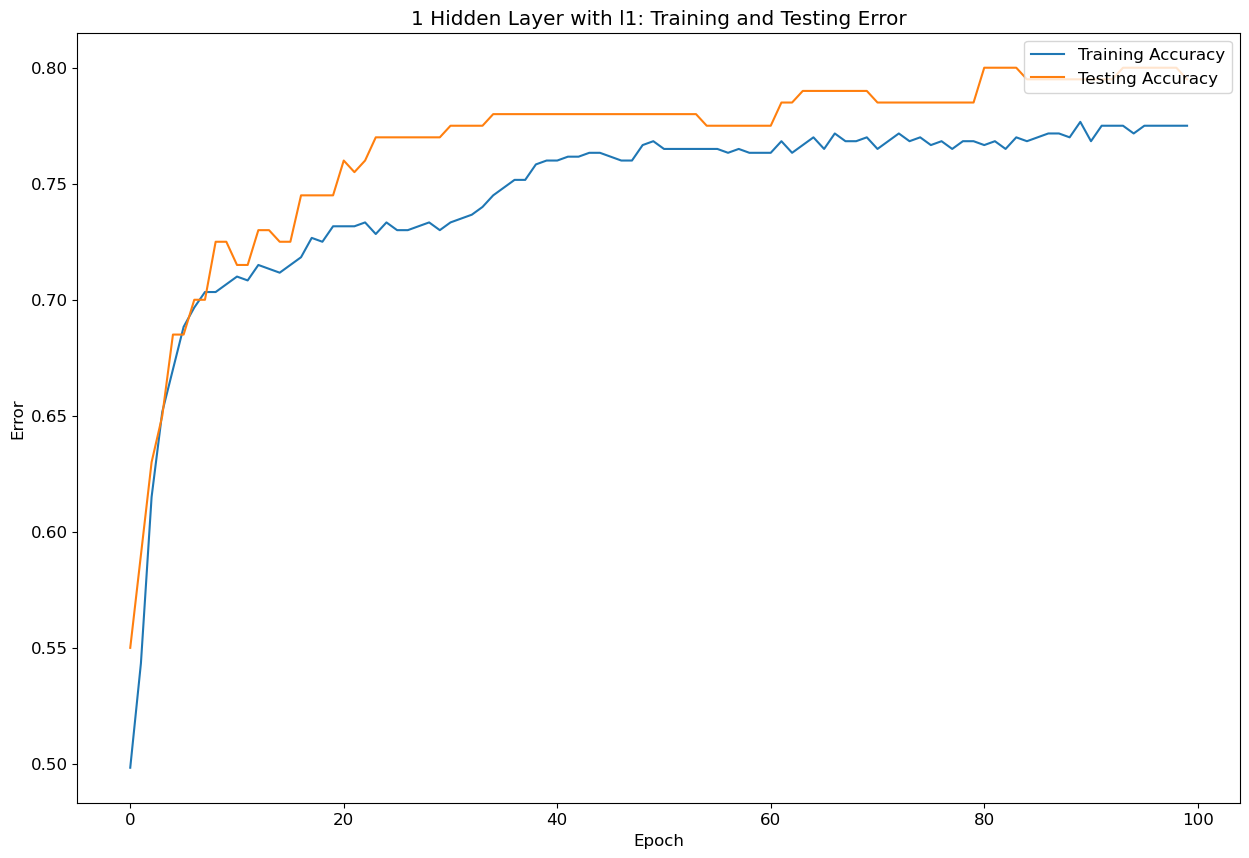

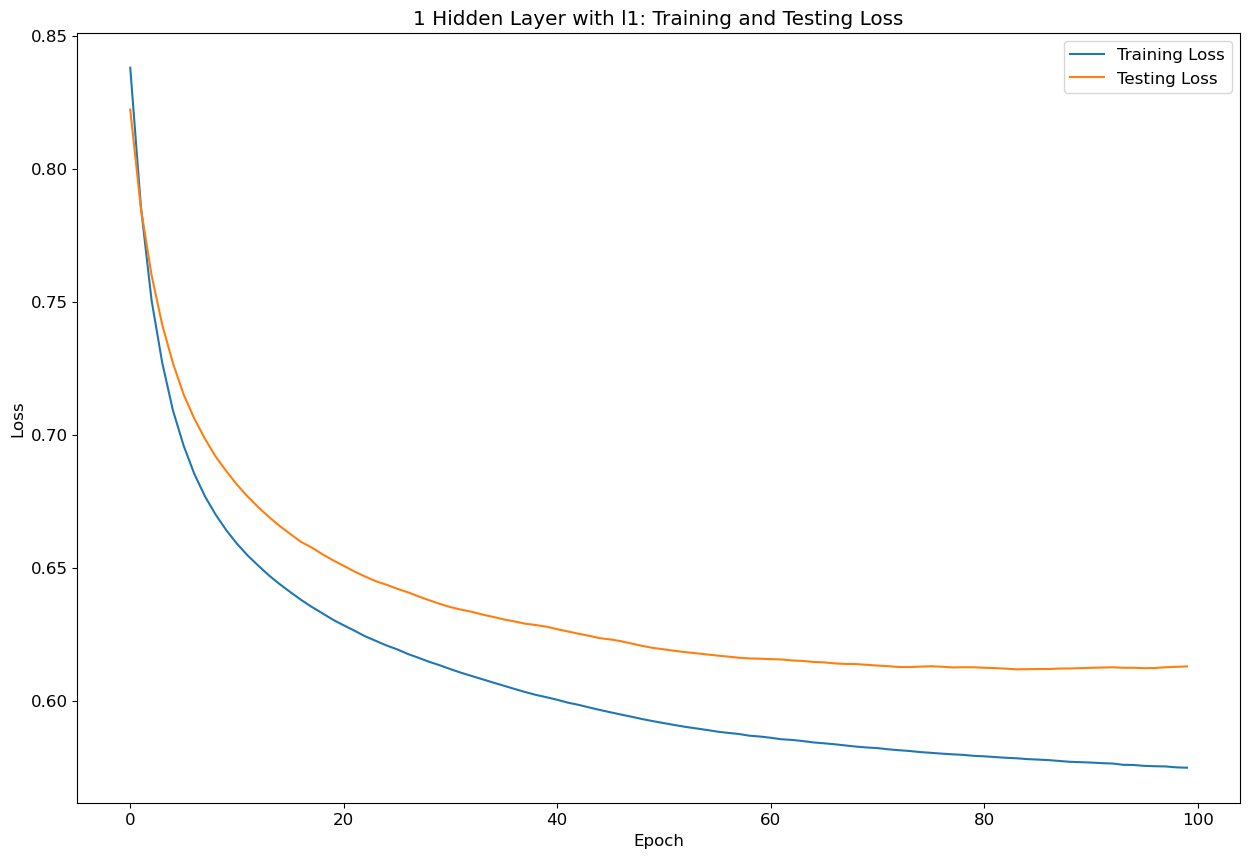

In [36]:
# Plot the accuracy and loss.

# Accuracy
plt.figure(figsize=(15, 10))
plt.plot(fit_model.history['accuracy'])
plt.plot(fit_model.history['val_accuracy'])
plt.title('1 Hidden Layer with l1: Training and Testing Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper right')
plt.show()

# Loss
plt.figure(figsize=(15, 10))
plt.plot(fit_model.history['loss'])
plt.plot(fit_model.history['val_loss'])
plt.title('1 Hidden Layer with l1: Training and Testing Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
plt.show()

#### 3. Building model with 1 hidden layer, l2 regularization and dropout layers

In [37]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import pandas as pd

In [38]:
seed_nb = 12
np.random.seed(seed_nb)
tf.random.set_seed(seed_nb)

# Create neural network base model
model = tf.keras.Sequential()

# Add 1 hidden layer1, 1 dropout layer and 1 output layer to the model
# Hidden layer 1
model.add(Dense(10, activation='relu', input_dim=8, kernel_regularizer=tf.keras.regularizers.l2(0.005)))
model.add(tf.keras.layers.Dropout(0.01))

# Add output layer to the model
model.add(Dense(2, activation='softmax'))

In [39]:
# Compile model
model.compile(optimizer=SGD(learning_rate = 0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                90        
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22        
Total params: 112
Trainable params: 112
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
# Training the model.
fit_model = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test), 
                      epochs=50, 
                      batch_size=16)

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print('\n\n Loss', loss, 'Accuracy:', accuracy)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/38 [..............................] - ETA: 4s - loss: 1.0506 - accuracy: 0.4375WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x159020700> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=

Epoch 45/50
38/38 [==============================] - 0s 881us/step - loss: 0.5275 - accuracy: 0.7333 - val_loss: 0.7032 - val_accuracy: 0.7000
Epoch 46/50
38/38 [==============================] - 0s 849us/step - loss: 0.5032 - accuracy: 0.7391 - val_loss: 0.7834 - val_accuracy: 0.6500
Epoch 47/50
38/38 [==============================] - 0s 846us/step - loss: 0.5509 - accuracy: 0.7241 - val_loss: 0.6939 - val_accuracy: 0.7000
Epoch 48/50
38/38 [==============================] - 0s 873us/step - loss: 0.5282 - accuracy: 0.7408 - val_loss: 0.7922 - val_accuracy: 0.6600
Epoch 49/50
38/38 [==============================] - 0s 846us/step - loss: 0.5217 - accuracy: 0.7341 - val_loss: 0.9130 - val_accuracy: 0.6400
Epoch 50/50
7/7 [==============================] - 0s 421us/step - loss: 0.7116 - accuracy: 0.6600


 Loss 0.7116307020187378 Accuracy: 0.6600000262260437


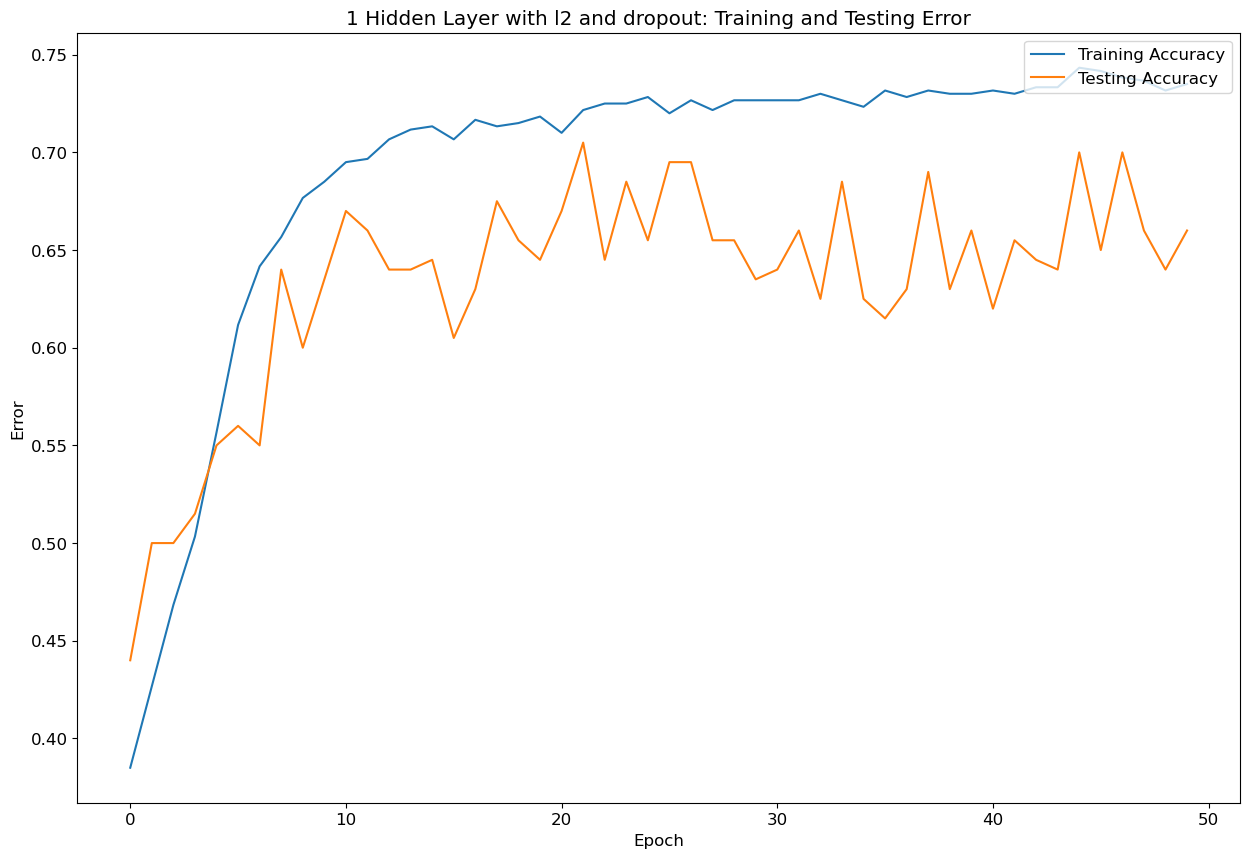

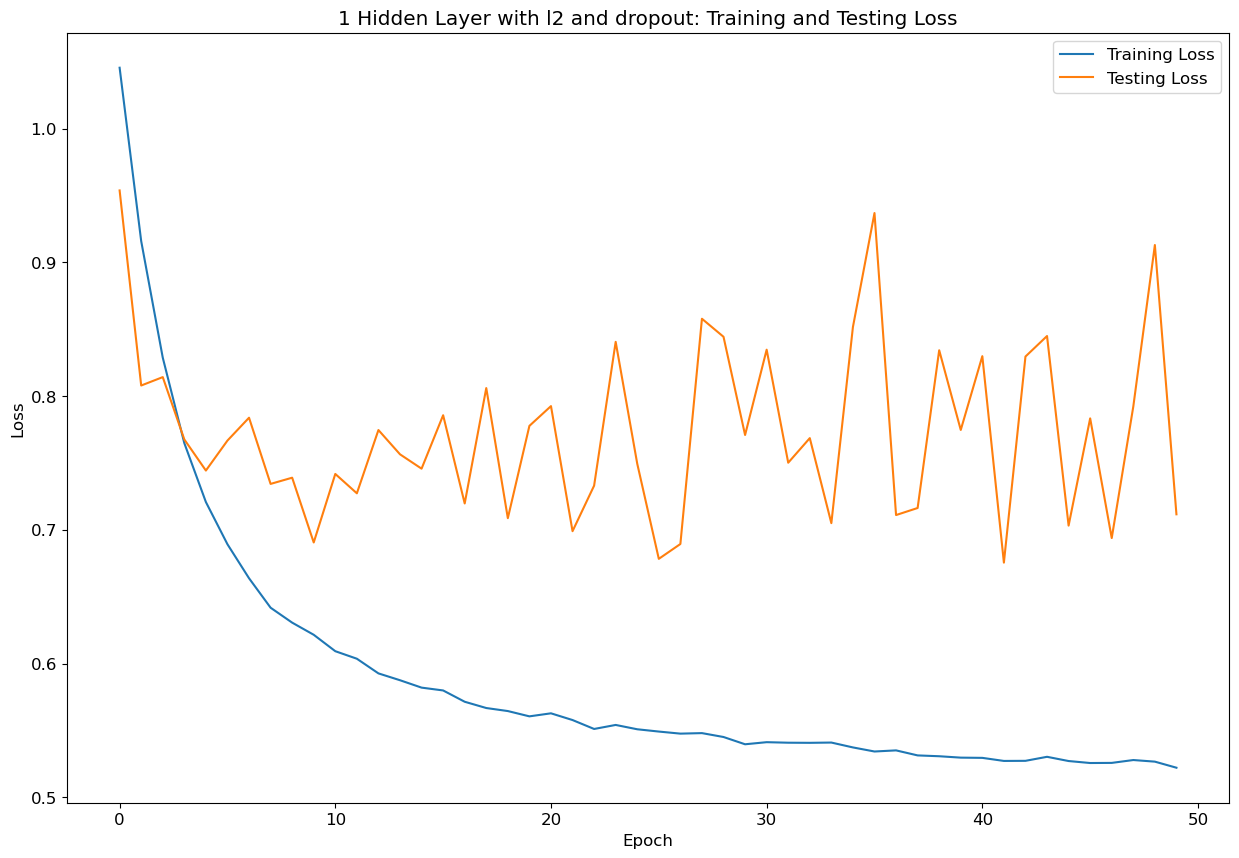

In [41]:
# Plot the accuracy and loss.

# Accuracy
plt.figure(figsize=(15, 10))
plt.plot(fit_model.history['accuracy'])
plt.plot(fit_model.history['val_accuracy'])
plt.title('1 Hidden Layer with l2 and dropout: Training and Testing Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper right')
plt.show()

# Loss
plt.figure(figsize=(15, 10))
plt.plot(fit_model.history['loss'])
plt.plot(fit_model.history['val_loss'])
plt.title('1 Hidden Layer with l2 and dropout: Training and Testing Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
plt.show()